<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-04-17 14:29:49--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2019-04-17 14:29:49 (12.5 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df = df.sample(frac = 1)
df.reset_index(drop = True, inplace = True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,326,326,COLLECTION,800,15,9/11/2016,9/25/2016,35,Bechalor,male
1,337,337,COLLECTION,1000,30,9/11/2016,10/10/2016,23,High School or Below,male
2,299,299,PAIDOFF,1000,30,9/14/2016,10/13/2016,28,college,male
3,207,207,PAIDOFF,1000,30,9/12/2016,10/11/2016,27,college,male
4,77,77,PAIDOFF,1000,30,9/11/2016,10/10/2016,35,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,326,326,COLLECTION,800,15,2016-09-11,2016-09-25,35,Bechalor,male
1,337,337,COLLECTION,1000,30,2016-09-11,2016-10-10,23,High School or Below,male
2,299,299,PAIDOFF,1000,30,2016-09-14,2016-10-13,28,college,male
3,207,207,PAIDOFF,1000,30,2016-09-12,2016-10-11,27,college,male
4,77,77,PAIDOFF,1000,30,2016-09-11,2016-10-10,35,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
seaborn                   0.9.0                    py35_0    anaconda


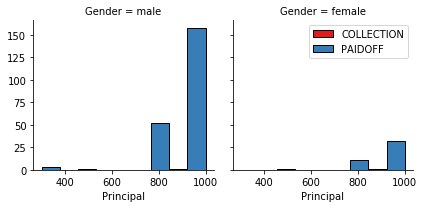

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

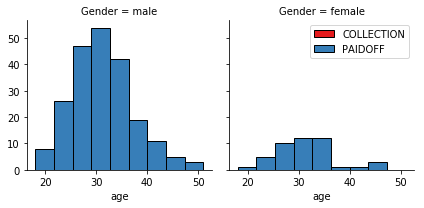

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

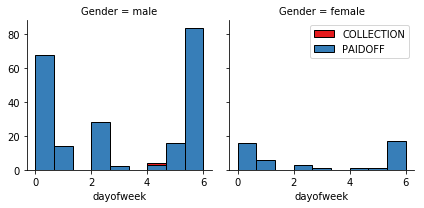

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,326,326,COLLECTION,800,15,2016-09-11,2016-09-25,35,Bechalor,male,6,1
1,337,337,COLLECTION,1000,30,2016-09-11,2016-10-10,23,High School or Below,male,6,1
2,299,299,PAIDOFF,1000,30,2016-09-14,2016-10-13,28,college,male,2,0
3,207,207,PAIDOFF,1000,30,2016-09-12,2016-10-11,27,college,male,0,0
4,77,77,PAIDOFF,1000,30,2016-09-11,2016-10-10,35,college,male,6,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,326,326,COLLECTION,800,15,2016-09-11,2016-09-25,35,Bechalor,0,6,1
1,337,337,COLLECTION,1000,30,2016-09-11,2016-10-10,23,High School or Below,0,6,1
2,299,299,PAIDOFF,1000,30,2016-09-14,2016-10-13,28,college,0,2,0
3,207,207,PAIDOFF,1000,30,2016-09-12,2016-10-11,27,college,0,0,0
4,77,77,PAIDOFF,1000,30,2016-09-11,2016-10-10,35,college,0,6,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,800,15,35,0,Bechalor
1,1000,30,23,0,High School or Below
2,1000,30,28,0,college
3,1000,30,27,0,college
4,1000,30,35,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,800,15,35,0,1,1,0,0
1,1000,30,23,0,1,0,1,0
2,1000,30,28,0,0,0,0,1
3,1000,30,27,0,0,0,0,1
4,1000,30,35,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,800,15,35,0,1,1,0,0
1,1000,30,23,0,1,0,1,0
2,1000,30,28,0,0,0,0,1
3,1000,30,27,0,0,0,0,1
4,1000,30,35,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'], dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-1.31458942, -0.95911111,  0.67333883, -0.42056004,  0.82934003,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458,  0.92071769, -1.31648524, -0.42056004,  0.82934003,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769, -0.48739188, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769,  0.67333883, -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [39]:
#change y to be numeric
y_num = pd.Series(y).replace(to_replace = ['PAIDOFF','COLLECTION'], value=[0,1])
y_num = y_num.values

In [40]:
#import all necessary function
from sklearn.cross_validation import train_test_split
from sklearn.metrics import jaccard_similarity_score, f1_score, log_loss

In [41]:
#import model
from sklearn.neighbors import KNeighborsClassifier

#train_test_split with validation size of 20%
x_train, x_test, y_train, y_test = train_test_split(X, y_num, test_size =0.2, random_state = 0)

#initializing parameters
#evaluating k from 1 to 20
Setk = range(1,21)
F1Score = []
JaccardScore = []

Text(0.5,1,'Performance Plot for KNN Model')

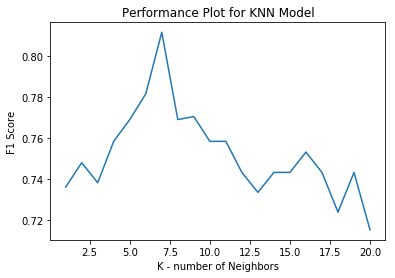

In [42]:
#find the best k
# step1. initialize the model
# step2. fit the model to the training set
# step3. record the performance in the validation set
for k in Setk:
    kmod = KNeighborsClassifier(n_neighbors=k)
    kmod.fit(x_train, y_train)
    F1Score.append(f1_score(y_test, kmod.predict(x_test), average ='weighted'))
    JaccardScore.append(jaccard_similarity_score(y_test, kmod.predict(x_test)))

#plotting section
plt.plot(Setk,F1Score )
plt.ylabel('F1 Score')
plt.xlabel('K - number of Neighbors')
plt.title('Performance Plot for KNN Model')

In [43]:
#choose k = 6 to build final model and train on all validation set
finalKMod = KNeighborsClassifier(n_neighbors = 6)
finalKMod.fit(X, y_num)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

# Decision Tree

In [25]:
#import model
from sklearn.tree import DecisionTreeClassifier

#train_test_split with validation size of 20%
x_train, x_test, y_train, y_test = train_test_split(X, y_num, test_size =0.2, random_state = 0)

#initializing parameters
#evaluating depth from 1 to 8
SetDepth = range(1,9)
F1Score = []
JaccardScore = []

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,1,'Performance Plot for Decision Tree Model')

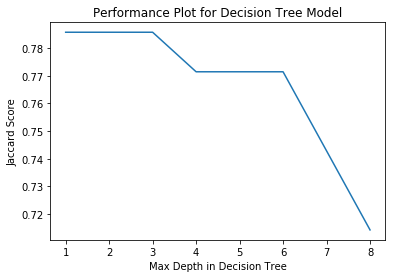

In [26]:
#find the best max_depth
# step1. initialize the model
# step2. fit the model to the training set
# step3. record the performance in the validation set
for depth in SetDepth:
    treemod = DecisionTreeClassifier(max_depth = depth)
    treemod.fit(x_train, y_train)
    F1Score.append(f1_score(y_test, treemod.predict(x_test), average ='weighted'))
    JaccardScore.append(jaccard_similarity_score(y_test, treemod.predict(x_test)))
    
#plotting section
plt.plot(SetDepth,JaccardScore )
plt.ylabel('Jaccard Score')
plt.xlabel('Max Depth in Decision Tree')
plt.title('Performance Plot for Decision Tree Model')


In [27]:
#select max_depth of 3
finalTreeMod = DecisionTreeClassifier(max_depth = 3)
finalTreeMod.fit(X, y_num)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

# Support Vector Machine

In [28]:
#import model
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#No need to split the data in this section 
#x_train, x_test, y_train, y_test = train_test_split(X, y_num, test_size =0.2, random_state = 0)

#initializing parameters
#evaluating depth from 1 to 8
gridPara = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2,3,4], 'C': [0.001,0.01,0.1,1,10,100,1000] }
F1Score = []
JaccardScore = []

In [29]:
#create grid and optimize the parameters: kernel, degree of polynomial and C
grid = GridSearchCV(estimator = SVC(), param_grid = gridPara, scoring = 'accuracy', cv = 5)
grid.fit(X, y_num)
finalSVMMod = grid.best_estimator_
print('score:', grid.best_score_)
print('best parameters:', grid.best_params_)

score: 0.751445086705
best parameters: {'kernel': 'linear', 'degree': 2, 'C': 0.001}


# Logistic Regression

In [30]:
#import model
from sklearn.linear_model import LogisticRegression

#train_test_split with validation size of 20%
x_train, x_test, y_train, y_test = train_test_split(X, y_num, test_size =0.2, random_state = 0)

#initializing parameters
#evaluating depth from 1 to 8
gridPara = {'C': [0.001,0.01,0.1,1,10,100,1000]}
F1Score = []
JaccardScore = []
logLossScore = []

In [31]:
#create grid and optimize the parameters: kernel, degree of polynomial and C
grid = GridSearchCV(estimator = LogisticRegression(), param_grid = gridPara, scoring = 'neg_log_loss', cv = 5)
grid.fit(X, y_num)
finalLogisticMod = grid.best_estimator_
print('score:', grid.best_score_)
print('best parameters:', grid.best_params_)

score: -0.454662501588
best parameters: {'C': 1}


# Model Evaluation using Test set

In [32]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [33]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-04-17 14:34:58--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-04-17 14:34:58 (510 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [44]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [45]:
#transform test_df

#convert date time and compute weekend
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if(x>3) else 0)

#replace male = 0, female = 1
test_df['Gender'].replace(to_replace = ['male', 'female'], value = [0,1], inplace = True)

#one hot encoding to education column
test_feature = test_df[['Principal','terms','age','Gender','weekend']]
test_feature = pd.concat([test_feature, pd.get_dummies(test_df['education'])], axis = 1)
test_feature.drop(['Master or Above'], axis = 1, inplace = True)

test_feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [46]:
#obtain x_test
x_test = test_feature
#standardize x_test
from sklearn.preprocessing import StandardScaler
x_test = StandardScaler().fit(x_test).transform(x_test)

#obtain y_test
y_test = test_df['loan_status'].replace(to_replace = ['PAIDOFF','COLLECTION'], value=[0,1]).values
print(y_test[0:5])

[0 0 0 0 0]


In [47]:
#algorithm column

Result = {'Algorithm': ['KNN', 'Decision Tree','SVM', 'Logistic Regression']}

#make prediction
y_hat_k = finalKMod.predict(x_test)
y_hat_tree = finalTreeMod.predict(x_test)
y_hat_svm = finalSVMMod.predict(x_test)
y_hat_log = finalLogisticMod.predict(x_test)
y_hatprob_log = finalLogisticMod.predict_proba(x_test)

In [48]:
#Jaccard column
Result['Jaccard'] = [jaccard_similarity_score(y_test, y_hat_k), jaccard_similarity_score(y_test, y_hat_tree), jaccard_similarity_score(y_test, y_hat_svm), jaccard_similarity_score(y_test, y_hat_log)]
#F1-score column
Result['F1-score'] = [f1_score(y_test, y_hat_k, average ='weighted'), f1_score(y_test, y_hat_tree, average ='weighted'), f1_score(y_test, y_hat_svm, average ='weighted'), f1_score(y_test, y_hat_log, average ='weighted')]
#Log loss
Result['Log loss'] = [np.nan, np.nan, np.nan, log_loss(y_test, y_hatprob_log)]

#create df and print
result_df = pd.DataFrame(Result)
result_df

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Algorithm,F1-score,Jaccard,Log loss
0,KNN,0.728821,0.759259,NaN
1,Decision Tree,0.630418,0.740741,NaN
2,SVM,0.630418,0.740741,NaN
3,Logistic Regression,0.671764,0.759259,0.479193


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>